In [ ]:
!pip install torchvision
!pip install torcheval
!git clone https://github.com/panoskyr/thetorchexperience.git
%cd thetorchexperience


In [ ]:
!pip install torchmetrics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from pprint import pprint
from skimage.io import imread
from torch.utils.data import DataLoader
import thetorchexperience.utils
from thetorchexperience.models import HumerusDataset, BaselineNN, HistEqualizationTransform,class6_Dataset, ResnetTransfer
import torch
from torch import nn
import torchvision
import torcheval
from torcheval.metrics import BinaryAccuracy
print(f'Pytorch version: {torch.__version__}, Torchvision version: {torchvision.__version__}')
murapath=os.path.join('/content/drive/MyDrive','Colab Notebooks/')
codepath='/content/thetorchexperience'

Pytorch version: 2.0.1+cu118, Torchvision version: 0.15.2+cu118


In [7]:
everythingScans_df=pd.read_csv('everythingScans_df.csv')
everythingScans_df['path']=murapath+everythingScans_df['path']
everythingScans_df['path']=everythingScans_df['path'].replace({r'\\':'/'},regex=True)

We check if some data is missing

In [17]:
print(everythingScans_df.isnull().values.any())
a=[0 if (x=='positive' or x=='negative') else 1 for x in everythingScans_df['Label'] ]
print(sum(a))

False
0


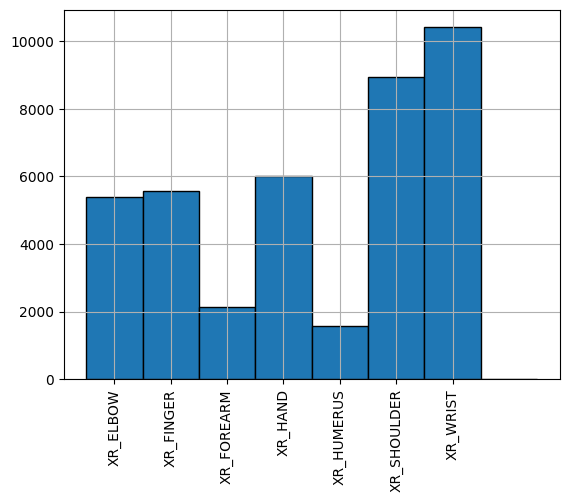

In [18]:

everythingScans_df['Bone'].hist(bins=range(0,9),rwidth=1, align='left',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

# Explore some examples of images
When groupping by two values we need to define how the values will be combined.
get combinations of pics with same label and bone then choose one randomly

In [19]:
onePairPic_df=everythingScans_df.groupby(['Label','Bone']).apply(lambda x:x.sample(1))
onePairPic_df.reset_index(drop=True)

,path,Split,Bone,Patient,FolderName,Study,Label
0,/content/drive/MyDrive/Colab Notebooks/MURA-v1...,train,XR_ELBOW,patient05482,study1_negative,study1,negative
1,/content/drive/MyDrive/Colab Notebooks/MURA-v1...,train,XR_FINGER,patient04353,study1_negative,study1,negative
2,/content/drive/MyDrive/Colab Notebooks/MURA-v1...,train,XR_FOREARM,patient09489,study1_negative,study1,negative
3,/content/drive/MyDrive/Colab Notebooks/MURA-v1...,train,XR_HAND,patient11049,study1_negative,study1,negative
4,/content/drive/MyDrive/Colab Notebooks/MURA-v1...,train,XR_HUMERUS,patient02951,study1_negative,study1,negative
5,/content/drive/MyDrive/Colab Notebooks/MURA-v1...,train,XR_SHOULDER,patient02309,study1_negative,study1,negative
6,/content/drive/MyDrive/Colab Notebooks/MURA-v1...,train,XR_WRIST,patient07962,study1_negative,study1,negative
7,/content/drive/MyDrive/Colab Notebooks/MURA-v1...,train,XR_ELBOW,patient05236,study1_positive,study1,positive
8,/content/drive/MyDrive/Colab Notebooks/MURA-v1...,train,XR_FINGER,patient03743,study1_positive,study1,positive
9,/content/drive/MyDrive/Colab Notebooks/MURA-v1...,train,XR_FOREARM,patient09264,study1_positive,study1,positive


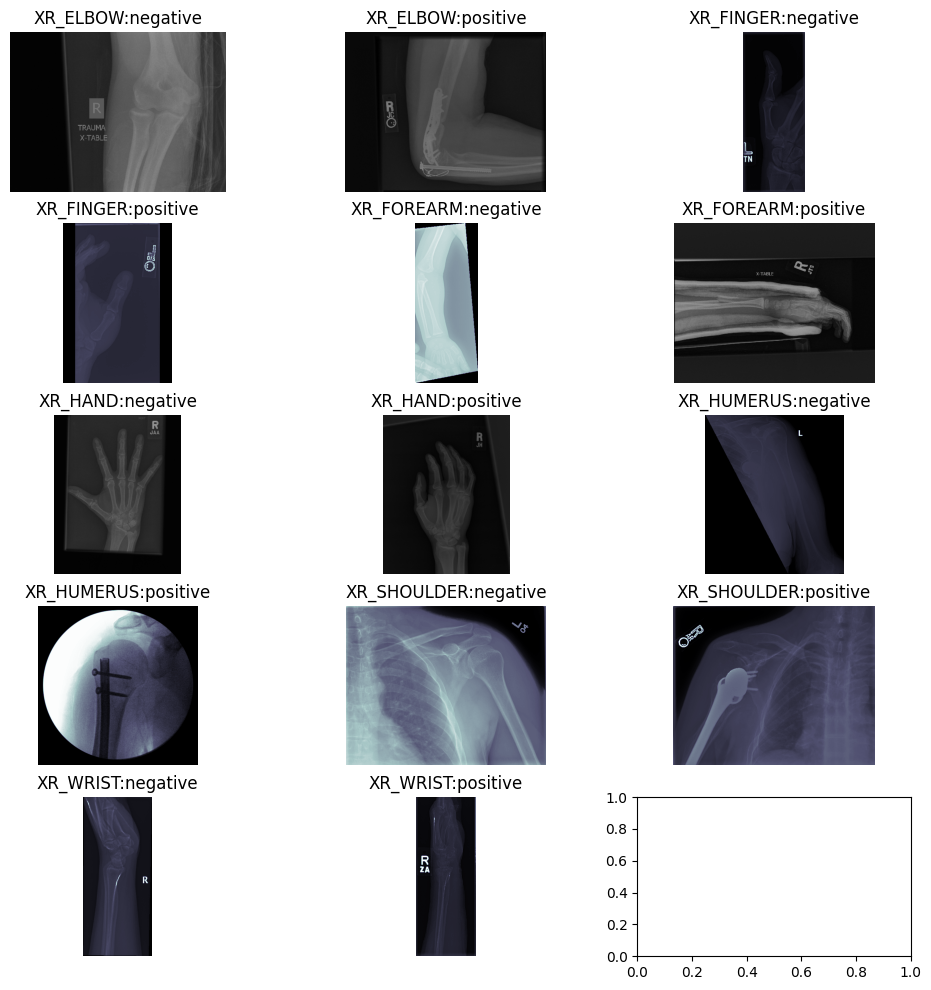

In [21]:
sub_df = everythingScans_df.groupby(['Bone', 'Label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(5, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{Bone}:{Label}'.format(**c_row))

In [26]:
def train(model, dataloader, loss_fn, optimizer, num_epochs=5, pretrained=False):

    #put in training mode
    model.train()
    #reset model parameters
    if not pretrained:
        model.reset_parameters()


    loss_history=[]
    for epoch in range(num_epochs):
        loss_per_epoch=0


        print(f"Epoch {epoch+1}/{num_epochs}")

        #batch computations
        for i, (inputs, labels) in enumerate(dataloader):
            print("batch number",i)

            outputs=model(inputs).squeeze()
            print("predictions probabilities are: ",outputs[:2])
            outputs.type_as(labels)
            #labels=labels.type_as(outputs)
            print("real labels: ",labels[:2])
            #loss returns mean loss per batch unless specified otherwise

            batch_loss=loss_fn(outputs,labels)

            #add the batch_loss to epoch loss
            loss_per_epoch+=batch_loss.item()

            optimizer.zero_grad()
            #update parameters
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            #print(i, loss.item())
            # if i%8==0:
            #     print(f"Loss at iteration {i} is {round((loss_per_epoch/8),4)}")
            #     #loss_istory has acumulated the mean loss of 8 batches so we divide by 4 to get
            #     # avg loss per batch
            #     loss_history.append(round((loss_per_epoch/8),4))
            #     loss_per_epoch=0
            if i % 9 == 0:
                print(f"Cumuative Loss at batch {i} is {round((loss_per_epoch/9),4)}")


        print(f"Loss at epoch {epoch+1} is {round((loss_per_epoch/len(dataloader)),4)}")
        loss_history.append(round((loss_per_epoch/len(dataloader)),4))
    return loss_history

@torch.no_grad()
def evaluate(model, dataloader, loss_fn, accuracy_fn, pretrained=False):
    model.eval()

    loss_history=[]
    eval_loss=0
    eval_acc=0

    for i, (inputs, labels) in enumerate(dataloader):
        print(inputs.dtype,labels.dtype)
        # if pretrained:
        #     pass
        # else:
        #     inputs=inputs.view(inputs.shape[0],-1)
        # if pretrained:
        #     outputs=model(inputs).squeeze()
        # else:
        #     outputs=model(inputs)
        outputs=model(inputs)
        #labels=labels.type_as(outputs)
        outputs.type_as(labels)
        loss=loss_fn(outputs,labels)
        eval_loss+=loss.item()
        accuracy_fn.update(outputs,labels)
        print("accuracy is: ",accuracy_fn.compute())
        #Binary accuracy returns the accuracy per batch
        # eg if batch size is 32 and 25 are correct, it returns tensor(25/32)
        eval_acc+=accuracy_fn.compute()

        loss_history.append(round(loss.item(),4))
    eval_loss=eval_loss/len(dataloader)
    eval_acc=eval_acc/len(dataloader)
    print(f"\n Test loss: {eval_loss:.5f}, Test acc: {eval_acc*100:.2f}%\n")
    return loss_history

In [27]:
from torchvision.models import ResNet18_Weights

transformation_dict= {

    'train':torchvision.transforms.Compose([]),

    'train_resnet': torchvision.transforms.Compose(
        [ResNet18_Weights.DEFAULT.transforms(),
        torchvision.transforms.RandomAutocontrast(p=0.5),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
    ]
    )


}

In [39]:
train_df=pd.read_csv('/content/thetorchexperience/MURA_fn_train.csv',index_col=0)
train_df['path']=murapath+train_df['path']
train_df['path']=train_df['path'].replace({r'\\':'/'},regex=True)

In [50]:
from torchvision.models import ResNet18_Weights
from torch.utils.data import Dataset, DataLoader
from PIL import Image
class class6_Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform=transform
        if self.transform is None:
            self.transform = ResNet18_Weights.DEFAULT.transforms()
        else:
            self.transform = transform
        #mapping alphabetically
        self.labels = self.df['Bone'].map({
            'XR_ELBOW': 0,
            'XR_FINGER': 1,
            'XR_FOREARM': 2,
            'XR_HAND': 3,
            'XR_HUMERUS': 4,
            'XR_SHOULDER': 5,
            'XR_WRIST': 6
        })

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path=self.df['path'].iloc[idx]
        pil_img=Image.open(path).convert('RGB')
        #print("pil_img shape:",pil_img.size,"pil_img mode:",pil_img.mode)
        img=self.transform(pil_img)
        img=torchvision.transforms.functional.convert_image_dtype(img,torch.float32)
        return img, self.labels.iloc[idx]

In [1]:
train_dataloader=DataLoader(class6_Dataset(train_df, transform=transformation_dict['train_resnet']),
                            batch_size=1024,
                            shuffle=True)
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape,train_labels_batch.shape)


NameError: ignored

In [44]:
everything_copy=everythingScans_df.copy()
everything_1000_train=everything_copy.loc[everything_copy['Split']=='train']
ev_1000_train_df=everything_1000_train.groupby(['Bone', 'Label']).apply(lambda x: x.sample(500)).reset_index(drop = True)
# ev_1000_train_df['Bone'].hist(bins=range(1,9),rwidth=1, align='left',edgecolor='black')
# plt.xticks(rotation=90)
# plt.show()
# ev_1000_train_df['Label'].hist()
train_dataloader=DataLoader(class6_Dataset(ev_1000_train_df,transform=transformation_dict['train_resnet']),batch_size=128,shuffle=True)
everything_100_valid=everything_copy.loc[everything_copy['Split']=='valid']
ev_100_valid_df=everything_100_valid.groupby(['Bone', 'Label']).apply(lambda x: x.sample(100)).reset_index(drop = True)
train_features_batch, train_labels_batch = next(iter(train_dataloader))
valid_dataloader=DataLoader(class6_Dataset(ev_100_valid_df,transform=None),batch_size=32,shuffle=True)
valid_features_batch, valid_labels_batch = next(iter(valid_dataloader))


AttributeError: ignored

In [ ]:
from torchmetrics import Accuracy

#PHASE 1 ...

loss_fn=torch.nn.CrossEntropyLoss(reduction='mean')
model = ResnetTransfer(train_resnet=True)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
accuracy_fn=Accuracy(task='multiclass', num_classes=7,threshold=0.5)
train_loss_history=train(model, train_dataloader, loss_fn, optimizer, num_epochs=2, pretrained=True)
#valid_loss_history=evaluate(model, valid_dataloader, loss_fn,accuracy_fn, pretrained=True)

#PHASE 2 ...
model.trigger_phase2()

loss_fn=torch.nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
accuracy_fn=Accuracy(task='binary', num_classes=2,threshold=0.5)
train_loss_history=train(model, train_dataloader, loss_fn, optimizer, num_epochs=2, pretrained=True)
#valid_loss_history=evaluate(model, valid_dataloader, loss_fn,accuracy_fn, pretrained=True)

import time

import time
now = time.ctime().lower().replace(' ','_').replace(':','-')
torch.save('./models/resnet_2phase/{}'.format(now))

batch number 0


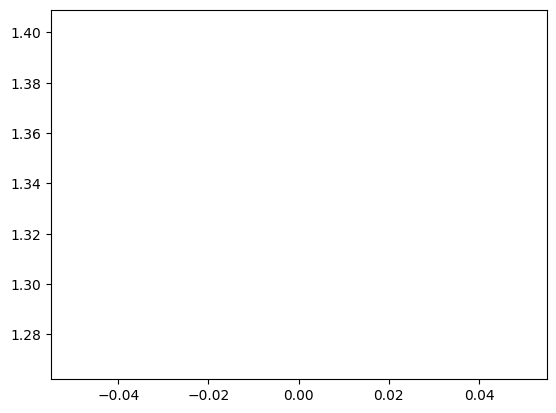

In [ ]:

plt.plot(train_loss_history, label='train')

#plt.plot(valid_loss_history, label='valid')

In [ ]:
#freeze all layers
#use weights and default so as not to get warnings
#use pretrained weights
weights=torchvision.models.ResNet18_Weights.DEFAULT
resnet18 = torchvision.models.resnet18(weights=weights)
for param in resnet18.parameters():
    param.requires_grad=False

weights.transforms()
in_features=resnet18.fc.in_features
#output only 1 value for binary classification
#the output is not passed through sigmoid
resnet18.fc=torch.nn.Linear(in_features,1)
#torchinfo.summary(resnet18, input_size=(32, 3, 256, 256),col_names=["input_size", "output_size", "num_params", "trainable"], verbose=2)
#only optimize the parameters of the last layer
optimizer=torch.optim.Adam(resnet18.fc.parameters(),lr=0.001)
input_size = 3*train_features_batch.shape[2]*train_features_batch.shape[3]
print(f"Input size: {input_size}")
loss_fn=torch.nn.BCEWithLogitsLoss(reduction='mean')
accuracy_fn=torcheval.metrics.BinaryAccuracy(threshold=0.5)
model=resnet18
optimizer=torch.optim.Adam(model.fc.parameters(),lr=0.001)

train_loss_history=train(model, train_dataloader, loss_fn, optimizer, num_epochs=1, pretrained=True)
valid_loss_history=evaluate(model, valid_dataloader, loss_fn,accuracy_fn, pretrained=True)

